<a href="https://colab.research.google.com/github/denizdolek/masterprojectdeniz/blob/main/yeniproje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Sep  6 20:25:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 353 µs (started: 2021-09-06 20:25:36 +00:00)


In [3]:
!pip install simpletransformers


time: 3.32 s (started: 2021-09-06 20:25:36 +00:00)


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import numpy as np
import itertools
import numpy as np


time: 661 ms (started: 2021-09-06 20:25:40 +00:00)


In [5]:
from simpletransformers.ner import NERModel,NERArgs


time: 4.64 s (started: 2021-09-06 20:25:40 +00:00)


Load important libraries

In [6]:
data = pd.read_csv("ner_dataset.csv",encoding="latin1" )

time: 432 ms (started: 2021-09-06 20:25:45 +00:00)


In [7]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


time: 29.3 ms (started: 2021-09-06 20:25:46 +00:00)


We notice that there are many NaN values in ‘Sentence #” column, and we fill NaN by preceding values.

In [8]:
data =data.fillna(method ="ffill")

time: 162 ms (started: 2021-09-06 20:25:46 +00:00)


method='ffill': Ffill or forward-fill propagates the last observed non-null value forward until another non-null value is encountered

In [9]:
data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()


(47959, 35178, 17)

time: 175 ms (started: 2021-09-06 20:25:46 +00:00)


There are 47959 sentences that contain 35178 unique words and tagged by 17 tags.
The tags are not evenly distributed.

In [10]:
data.groupby('Tag').size().reset_index(name='counts')


,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


time: 77.2 ms (started: 2021-09-06 20:25:46 +00:00)


In [11]:
data.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


time: 18.6 ms (started: 2021-09-06 20:25:46 +00:00)


In [12]:
data.shape


(1048575, 4)

time: 2.72 ms (started: 2021-09-06 20:25:46 +00:00)


In [13]:
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
maxlen = max([len(s) for s in set(data["Word"].values)])
print ('Maximum sentence length:', maxlen)

Number of words in the dataset:  35178
Maximum sentence length: 64
time: 129 ms (started: 2021-09-06 20:25:46 +00:00)


In [14]:
sns.set(color_codes=True)
sns.set(font_scale=1)

time: 2.87 ms (started: 2021-09-06 20:25:46 +00:00)


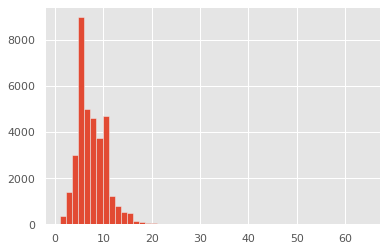

time: 360 ms (started: 2021-09-06 20:25:46 +00:00)


In [15]:
plt.style.use("ggplot")
plt.hist([len(s) for s in set(data["Word"].values)], bins=50)
plt.show()

In [16]:
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

time: 68.6 ms (started: 2021-09-06 20:25:47 +00:00)


In [17]:
data.loc[data['Tag'] == 'B-per', 'Word'].head()

42          Bush
270    President
331       Thomas
443    President
965      Prophet
Name: Word, dtype: object

time: 66 ms (started: 2021-09-06 20:25:47 +00:00)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


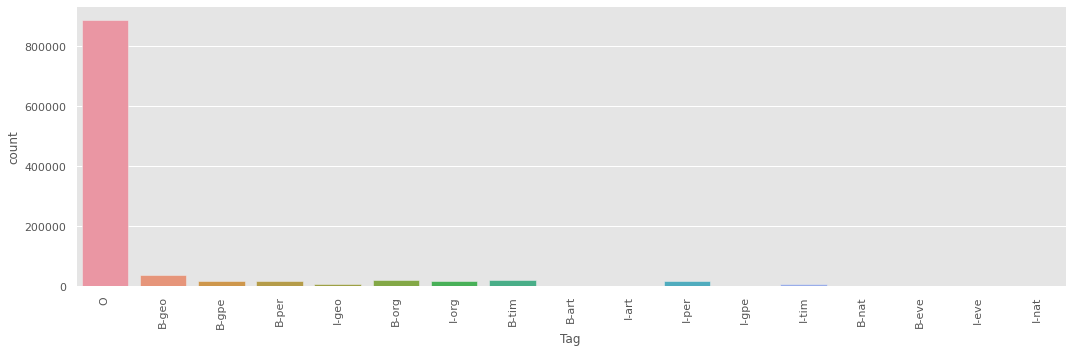

time: 834 ms (started: 2021-09-06 20:25:47 +00:00)


In [18]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

These words can be considered as fillers and their presence might impact the classifier performance as well.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


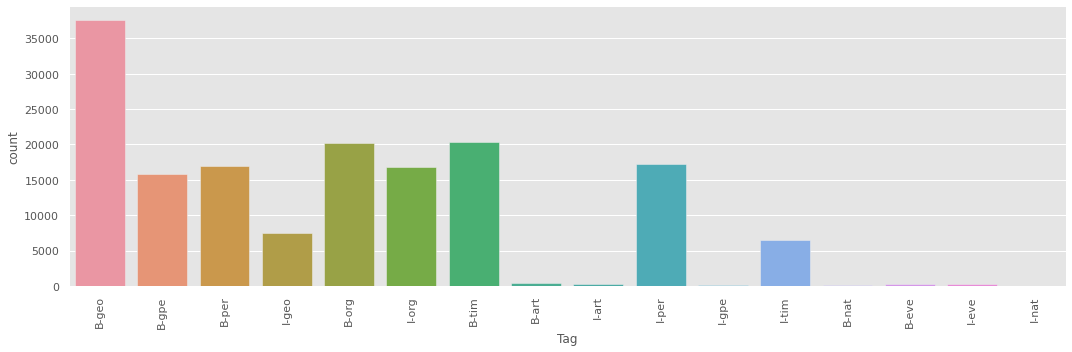

time: 527 ms (started: 2021-09-06 20:25:48 +00:00)


In [19]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('Tag', data=data.loc[data['Tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

So our dataset mostly contains words related to geographical locations, geopolitical entities and person names.



In [20]:
data["Sentence #"] = LabelEncoder().fit_transform(data["Sentence #"] )


time: 221 ms (started: 2021-09-06 20:25:48 +00:00)


Fit label encoder and return encoded labels.



In [21]:
data.rename(columns={"Sentence #":"sentence_id","Word":"words","Tag":"labels"}, inplace =True)


time: 1.01 ms (started: 2021-09-06 20:25:48 +00:00)


In [22]:
data["labels"] = data["labels"].str.upper()

time: 321 ms (started: 2021-09-06 20:25:48 +00:00)


In [23]:
X= data[["sentence_id","words"]]
Y =data["labels"]

time: 15.4 ms (started: 2021-09-06 20:25:49 +00:00)


In [24]:
print(X)

         sentence_id          words
0                  0      Thousands
1                  0             of
2                  0  demonstrators
3                  0           have
4                  0        marched
...              ...            ...
1048570        42177           they
1048571        42177      responded
1048572        42177             to
1048573        42177            the
1048574        42177         attack

[1048575 rows x 2 columns]
time: 9.09 ms (started: 2021-09-06 20:25:49 +00:00)


In [25]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2)


time: 213 ms (started: 2021-09-06 20:25:49 +00:00)


In [26]:
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

time: 56.7 ms (started: 2021-09-06 20:25:49 +00:00)


In [27]:
train_data


,sentence_id,words,labels
395854,8991,",",O
421280,10265,militants,O
986016,38981,capital,O
212993,47698,to,O
228394,504,all,O
...,...,...,...
148356,44357,'s,O
1003592,39883,first,O
316392,4980,aid,O
102963,40901,.,O


time: 16.4 ms (started: 2021-09-06 20:25:49 +00:00)


In [28]:
label = data["labels"].unique().tolist()

time: 50.8 ms (started: 2021-09-06 20:25:49 +00:00)


In [29]:
label

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'B-ART',
 'I-ART',
 'I-PER',
 'I-GPE',
 'I-TIM',
 'B-NAT',
 'B-EVE',
 'I-EVE',
 'I-NAT']

time: 2.16 ms (started: 2021-09-06 20:25:49 +00:00)


In [30]:
args = NERArgs()
args.num_train_epochs = 2
args.learning_rate = 5e-5
args.overwrite_output_dir =True

args.train_batch_size = 64
args.eval_batch_size = 64
args.max_seq_length = 128

time: 1.01 ms (started: 2021-09-06 20:25:49 +00:00)


Default Parameters:
"fp16": True,
"fp16_opt_level": "O1",
"max_seq_length": 128,
"train_batch_size": 8,
"gradient_accumulation_steps": 1,
"eval_batch_size": 8,
"num_train_epochs": 1,
"weight_decay": 0,
"learning_rate": 4e-5,
"adam_epsilon": 1e-8,
"warmup_ratio": 0.06,
"warmup_steps": 0,
"max_grad_norm": 1.0,
"logging_steps": 50,
"save_steps": 2000


In [31]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

time: 153 ms (started: 2021-09-06 20:25:49 +00:00)


Cleanin the cache.

In [32]:
model = NERModel('bert', 'bert-base-cased',labels=label,args =args)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

time: 14.6 s (started: 2021-09-06 20:25:49 +00:00)


bert-base-cased: 12-layer, 768-hidden, 12-heads, 109M parameters.
Trained on cased English text.

In [33]:
model.train_model(train_data,eval_data = test_data,acc=accuracy_score)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/750 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/ner/ner_model.py:775: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running Epoch 1 of 2:   0%|          | 0/750 [00:00<?, ?it/s]

(1500, 0.19039853477478028)

time: 12min 54s (started: 2021-09-06 20:26:04 +00:00)


In [34]:
result, model_outputs, preds_list = model.eval_model(test_data)


  0%|          | 0/2 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/730 [00:00<?, ?it/s]

time: 3min 15s (started: 2021-09-06 20:38:59 +00:00)


In [35]:
result

{'eval_loss': 0.17626673736392634,
 'precision': 0.8241655076495132,
 'recall': 0.7572117688400473,
 'f1_score': 0.78927126517157}

time: 3.95 ms (started: 2021-09-06 20:42:14 +00:00)


In [36]:
df = pd.read_csv("AWD_data.csv")

time: 30.1 ms (started: 2021-09-06 20:42:14 +00:00)


In [37]:
text = df["Text"]

time: 1.04 ms (started: 2021-09-06 20:42:14 +00:00)


In [38]:
words = list(text)
n_words = len(words)
print("Number of days in the dataset: ", n_words)


Number of days in the dataset:  2024
time: 2.42 ms (started: 2021-09-06 20:42:14 +00:00)


In [39]:
text.head(5)

0    Went to Halston's birthday dinner for Victor a...
1    I had to meet Miguel Bose (cab $6). He came to...
2    Henry Geldzahler came by to talk about me doin...
3    I was reading the Margaret Trudeau book. She w...
4    We photographed the street people in front of ...
Name: Text, dtype: object

time: 4 ms (started: 2021-09-06 20:42:14 +00:00)


In [40]:
count = 0
for totalwords in text:
    count += len(totalwords)

print('Total Words : ', count)

Total Words :  2246989
time: 2.44 ms (started: 2021-09-06 20:42:14 +00:00)


In [41]:
day1 = text[0]
day1

'Went to Halston\'s birthday dinner for Victor at Pearl\'s he did not want to do a big thing at the house. Joe Eula was there. And Aly Kaiser. She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home. She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana. She said she gave some to one of her bodyguards and he was passed out at home. She says she will let me take pictures of her as soon as she gets her divorce. Before it was "as soon as I get the plastic in my face from Dr. Orentreich." I talked to Dr. Giller he seems so sensible. He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food. He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said she would send one of her bodyguards down

time: 2.21 ms (started: 2021-09-06 20:42:14 +00:00)


In [42]:
abridgment = {'Dr.': 'doctor', 'Mr.': 'mister', 'bro.': 'brother', 'bro': 'brother', 
              'Mrs.': 'mistress', 'Ms.': 'miss', 'jr.': 'junior', 'sr.': 'senior', 'i.e.': 'for example', 'e.g.': 'for example', 
              'vs.': 'versus', 'Prof.': 'prof', 'A.M.': 'am','P.M.': 'pm', 'U.S.A.': 'USA', 'U.K.': 'UK'}
closers = ['.', '!', '?', '?']
wrappers = ['"', "'", ')', ']', '}']



time: 1.71 ms (started: 2021-09-06 20:42:14 +00:00)


In [43]:
def findall(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1:
            return
        yield start
        start += len(sub)

time: 947 µs (started: 2021-09-06 20:42:14 +00:00)


In [44]:
def endofsentence(textpredict):
    [possible_endings, contraction_locations] = [[], []]
    contractions = abridgment.keys()
    sentence_closers = closers + [closer + wrapper for wrapper in wrappers for closer in closers]
    
    for sentence_closer in sentence_closers:
        t_indices = list(findall(textpredict, sentence_closer))
        possible_endings.extend(([] if not len(t_indices) else [[i, len(sentence_closer)] for i in t_indices]))
    
    for contraction in contractions:
        c_indices = list(findall(textpredict, contraction))
        contraction_locations.extend(([] if not len(c_indices) else [i + len(contraction) for i in c_indices]))
    possible_endings = [pe for pe in possible_endings 
                        if pe[0] + pe[1] not in contraction_locations]
    if len(textpredict) in [pe[0] + pe[1] for pe in possible_endings]:
        max_end_start = max([pe[0] for pe in possible_endings])
        possible_endings = [pe for pe in possible_endings 
                            if pe[0] != max_end_start]
    
    possible_endings = [pe[0] + pe[1] for pe in possible_endings 
                        if sum(pe) > len(textpredict) or (sum(pe) < len(textpredict) and textpredict[sum(pe)] == ' ')]
    end = (-1 if not len(possible_endings) else max(possible_endings))
    return end


time: 3.25 ms (started: 2021-09-06 20:42:14 +00:00)


In [45]:
def getsentence(textpredict):
   end = True
   sentences = []
   while end > -1:
       end = endofsentence(textpredict)
       if end > -1:
           sentences.append(textpredict[end:].strip())
           textpredict = textpredict[:end]
   sentences.append(textpredict)
   sentences.reverse()
   return sentences

time: 1.2 ms (started: 2021-09-06 20:42:14 +00:00)


In [46]:
day1pred = getsentence(day1)

time: 2.79 ms (started: 2021-09-06 20:42:14 +00:00)


In [47]:
day1pred

["Went to Halston's birthday dinner for Victor at Pearl's he did not want to do a big thing at the house.",
 'Joe Eula was there.',
 'And Aly Kaiser.',
 'She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home.',
 'She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana.',
 'She said she gave some to one of her bodyguards and he was passed out at home.',
 'She says she will let me take pictures of her as soon as she gets her divorce.',
 'Before it was "as soon as I get the plastic in my face from Dr. Orentreich."',
 'I talked to Dr. Giller he seems so sensible.',
 'He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food.',
 'He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said sh

time: 3.14 ms (started: 2021-09-06 20:42:14 +00:00)


In [49]:
all = []
for day in text:
  sentences = getsentence(day)
  for sentence in sentences:
    all.append(sentence)

time: 1.98 s (started: 2021-09-06 20:45:52 +00:00)


In [50]:
predictiontest, model_output3 = model.predict(all)

  0%|          | 0/3 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/437 [00:00<?, ?it/s]

time: 1min 59s (started: 2021-09-06 20:46:01 +00:00)


In [51]:
predictiontest[0]

[{'Went': 'O'},
 {'to': 'O'},
 {"Halston's": 'I-PER'},
 {'birthday': 'O'},
 {'dinner': 'O'},
 {'for': 'O'},
 {'Victor': 'B-PER'},
 {'at': 'O'},
 {"Pearl's": 'B-GEO'},
 {'he': 'O'},
 {'did': 'O'},
 {'not': 'O'},
 {'want': 'O'},
 {'to': 'O'},
 {'do': 'O'},
 {'a': 'O'},
 {'big': 'O'},
 {'thing': 'O'},
 {'at': 'O'},
 {'the': 'O'},
 {'house.': 'O'}]

time: 3.8 ms (started: 2021-09-06 20:48:00 +00:00)


In [52]:
peoplelistnotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-PER' or value == 'I-PER' :
        peoplelistnotpair.append(word)


time: 167 ms (started: 2021-09-06 20:48:00 +00:00)


In [53]:
peoplelistnotpair[:5]

["Halston's", 'Victor', 'Joe', 'Eula', 'Aly']

time: 2.3 ms (started: 2021-09-06 20:48:00 +00:00)


In [54]:
len(peoplelistnotpair)

30568

time: 2.02 ms (started: 2021-09-06 20:48:00 +00:00)


In [55]:
peoplelistnotpairset = set(peoplelistnotpair)

time: 5.24 ms (started: 2021-09-06 20:48:00 +00:00)


In [56]:
print(peoplelistnotpairset)

{'Fraser-Morris', 'Norris', 'Nenna.', 'Kabler', 'Lumet.', 'Oz', 'Denton', 'David', 'Julio.', 'Bella.', 'Holzer.', 'Powers.', 'Sophie', 'Larry', "Mortimer's", 'Abbott', 'Pinter.', 'Hans.', 'Bufman', 'Plimpton?', 'Carter-he', 'Mustique.', 'Hodes', 'Arman', 'Tina', 'Ruskin', 'den', 'Soren', "Streisand's", "Trump's", 'Monique', 'Mickey."', "Armstrong's", 'Bates.', "Klein's", 'Galan', "Fergie's", "Max's", 'Hans', 'Etting', 'Samanna!', 'Weiss', 'Beard.', 'Marsha', 'McFadden."', "Starbuck's", "Regine's", 'Vic', 'Jagger.', 'Aurora', 'Ozbek', 'Jo', 'Horst', "Scavullo's.", 'Margaret', 'Bruce', 'Scull.', 'Camilla', 'Malleray', 'Dizzy', 'Tennant!', 'Chen', 'Sire', 'Cote', 'Diller', 'Mahler', 'Stait.', "Aurora's", 'Cerf', 'Bernet', 'Warhol"', 'Larsen', "Tiegs's", 'Pilar', 'Grahame.', 'Winger.', 'McKellen', 'Holland', 'Dana', 'Nadja', 'Kenzo', 'Farmanfarmian-Chris', 'Jerry', "Jasper's", 'Lancaster', 'Andy"-and', "Benton's", "Marder's", "Doyle's", 'Mitfords', "David's", 'DeVito', 'Knoll', 'Leo.', 'Fi

In [57]:
len(peoplelistnotpairset)

5371

time: 2.29 ms (started: 2021-09-06 20:48:00 +00:00)


In [58]:
Counter(peoplelistnotpair).most_common(10)

[('Bob', 553),
 ('Fred', 543),
 ('John', 378),
 ('Halston', 320),
 ('Jean', 319),
 ('Bianca', 311),
 ('Michel', 280),
 ('Victor', 260),
 ('Chris', 256),
 ('Jon', 255)]

time: 21.3 ms (started: 2021-09-06 20:48:00 +00:00)


In [59]:
prevalue="" 
preword=""
peoplepair=[]
for elem in predictiontest:
  for elem2 in elem:

    for word, value in elem2.items():

      newstring=""
      if value == 'B-PER' or value == 'I-PER' :
        if value == 'I-PER' and prevalue == 'B-PER':
          newstring = str(preword) + " " + str(word)
          del peoplepair[-1]
        else:
          newstring=word
        peoplepair.append(newstring)
        prevalue=value
        preword=word

time: 202 ms (started: 2021-09-06 20:48:00 +00:00)


In [60]:
peoplepair[:50]

["Halston's",
 'Victor',
 'Joe Eula',
 'Aly Kaiser.',
 'Victor',
 'Dr. Orentreich."',
 'Dr. Giller',
 'Mrs. Kaiser',
 'Miguel Bose',
 'Joe MacDonald',
 'Joe',
 'Veronica',
 'Muhammad Ali',
 'Ronnie Levin',
 'Muhammad',
 'Henry Geldzahler',
 'Fred',
 'Henry',
 'Henry',
 'Ellsworth',
 'Kelly',
 'Ellsworth',
 'Kelly',
 'Mayor Koch',
 'Rupert',
 'Ron Feldman',
 'Rock',
 'Harcourt',
 'Jackie Curtis',
 'Jovanovich',
 'Margaret Trudeau',
 'Viva Mork',
 'Robin Williams.',
 "Jed's",
 "Susan Mork's",
 'Sherry',
 'Lucie Arnaz',
 'Mork',
 'Jon Woods',
 'Richard Weisman',
 'Howard Cosell',
 "Reggie Jackson's",
 "Averil Meyer's",
 'Mrs. Payson',
 'Averil',
 'Yogi',
 'Berra',
 'Mickey Mantle',
 'Howard Cosell',
 'Richard']

time: 3.64 ms (started: 2021-09-06 20:48:01 +00:00)


In [61]:
len(peoplepair)

21585

time: 2.2 ms (started: 2021-09-06 20:48:01 +00:00)


In [62]:
Counter(peoplepair).most_common(10)

[('Fred', 475),
 ('Bob', 364),
 ('Jean Michel', 272),
 ('Bianca', 256),
 ('Basquiat', 236),
 ('Paige', 209),
 ('Brigid', 201),
 ('Jon', 199),
 ('Halston', 197),
 ('Catherine', 193)]

time: 11.7 ms (started: 2021-09-06 20:48:01 +00:00)


In [63]:
from statistics import mean
  
def Average(lst):
    return mean(lst)

time: 3.62 ms (started: 2021-09-06 20:48:01 +00:00)


In [64]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs


time: 1.69 ms (started: 2021-09-06 20:48:01 +00:00)


In [65]:
fredfrequence = list_duplicates_of(peoplelistnotpair, 'Fred')
print(list_duplicates_of(peoplelistnotpair, 'Fred'))
print(len(fredfrequence))
print("Position of Fred =", round(Average(fredfrequence), 2))


[26, 78, 85, 87, 146, 294, 296, 298, 481, 503, 540, 632, 698, 726, 773, 840, 969, 1125, 1128, 1192, 1262, 1264, 1440, 1470, 1519, 1533, 1625, 1647, 1720, 1868, 2057, 2060, 2093, 2195, 2198, 2215, 2240, 2256, 2267, 2272, 2273, 2328, 2343, 2365, 2425, 2426, 2437, 2454, 2561, 2599, 2600, 2607, 2608, 2609, 2647, 2650, 2683, 2725, 2938, 3004, 3005, 3199, 3233, 3236, 3237, 3242, 3286, 3321, 3372, 3374, 3377, 3388, 3475, 3480, 3487, 3667, 3681, 3722, 3725, 3727, 3957, 4015, 4023, 4213, 4340, 4624, 4671, 4674, 4677, 4732, 4738, 4742, 4783, 4784, 4795, 4796, 4800, 4843, 4860, 4901, 5128, 5169, 5222, 5227, 5306, 5309, 5363, 5425, 5539, 5678, 5724, 5750, 5893, 5908, 5918, 5919, 6008, 6026, 6116, 6212, 6215, 6217, 6299, 6362, 6375, 6404, 6414, 6497, 6543, 6684, 6685, 6686, 6704, 6707, 6743, 6744, 6777, 6871, 7339, 7367, 7368, 7505, 7520, 7522, 7637, 7646, 7648, 7705, 7921, 7940, 8284, 8299, 8307, 8381, 8408, 8528, 8560, 8565, 8573, 8856, 8858, 8859, 9169, 9384, 9406, 9552, 9933, 10090, 10240, 1024

In [66]:
Jonfrequence = list_duplicates_of(peoplelistnotpair, 'Jon')
print(list_duplicates_of(peoplelistnotpair, 'Jon'))
print(len(Jonfrequence))
print("Position of Jon =", round(Average(Jonfrequence), 2))

[56, 335, 345, 414, 570, 752, 853, 859, 865, 867, 1102, 1103, 1109, 1133, 1220, 1307, 1705, 1708, 1822, 1825, 1903, 1913, 2224, 2400, 2591, 2645, 2911, 3022, 3204, 3206, 3207, 3220, 3756, 3975, 4293, 4413, 4686, 4781, 4782, 5175, 5414, 5623, 5747, 5975, 6120, 6180, 6194, 6284, 6285, 6754, 7084, 7089, 7117, 7319, 7320, 7408, 7414, 7422, 7425, 7429, 8377, 8503, 8505, 8728, 9031, 9122, 9123, 9124, 9125, 9129, 9387, 9450, 9496, 9497, 9686, 9692, 9697, 9821, 9824, 9825, 9830, 9965, 9970, 10024, 10027, 10619, 10787, 10808, 10810, 10941, 10951, 10962, 11416, 11430, 11432, 11435, 11437, 11452, 11665, 11724, 11897, 11972, 11975, 12007, 12008, 12027, 12084, 12093, 12099, 12108, 12174, 12324, 12338, 12482, 12525, 12788, 12789, 12993, 13295, 13397, 13483, 13539, 13562, 13610, 13696, 13703, 13718, 13810, 13994, 13996, 13997, 13999, 14000, 14001, 14165, 14227, 14230, 14288, 14298, 14302, 14414, 14538, 15014, 15015, 15092, 15210, 15243, 15375, 15384, 15386, 15391, 15392, 15403, 15506, 15516, 15519, 1

In [67]:
xfrequence = list_duplicates_of(peoplelistnotpair, 'Brigid')
print(list_duplicates_of(peoplelistnotpair, 'Brigid'))
print(len(xfrequence))
print("Position of x =", round(Average(xfrequence), 2))

[156, 164, 395, 489, 665, 792, 833, 949, 971, 974, 1193, 1717, 1845, 1860, 2022, 2155, 2751, 3358, 3442, 3682, 3685, 3720, 3994, 4031, 4124, 4334, 4360, 4506, 4688, 4773, 4780, 4802, 4823, 4948, 4965, 4966, 4967, 4974, 4976, 4977, 5181, 5725, 6157, 6163, 6318, 6487, 6574, 6594, 7150, 7391, 7488, 7493, 7731, 8488, 8787, 8788, 8789, 9377, 9390, 9562, 9818, 10864, 11015, 11997, 12693, 12894, 12991, 13393, 13885, 13887, 14606, 14705, 14947, 15211, 15280, 15315, 15316, 15318, 15462, 15489, 15821, 15841, 15876, 15879, 16049, 16205, 16208, 16550, 16568, 16577, 16580, 16909, 16984, 17058, 17458, 18081, 18422, 18430, 18435, 18526, 18826, 18827, 18831, 18832, 18834, 18843, 18848, 18849, 18854, 18855, 18860, 18861, 18864, 18868, 18871, 18933, 19009, 19042, 19043, 19486, 19487, 19803, 19886, 19904, 20462, 20684, 20689, 20894, 20924, 20928, 21069, 21195, 21479, 21498, 21648, 21742, 21877, 21891, 22366, 22428, 22475, 22479, 22861, 22915, 22982, 23000, 23001, 23002, 23092, 23495, 24129, 24131, 24180,

In [68]:
dayslist=[]
predictlist=[]
for days in text[:10]:
  predictionpeople, model_output3 = model.predict([days])
  predictlist.append(predictionpeople)
  prevalue="" 
  preword=""
  peoplelist=[]
  for elem in predictionpeople:
    for elem2 in elem:

      for word, value in elem2.items():

        newstring=""
        if value == 'B-PER' or value == 'I-PER' :
          if value == 'I-PER' and prevalue == 'B-PER':
            newstring = str(preword) + " " + str(word)

            del peoplelist[-1]
          else:
            newstring=word
          peoplelist.append(newstring)
          prevalue=value
          preword=word
  dayslist.append(peoplelist)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

time: 4.3 s (started: 2021-09-06 20:48:01 +00:00)


In [69]:
dayslist

[["Halston's", 'Victor', "Pearl's", 'Joe Eula', 'Aly Kaiser.', 'Victor'],
 ['Miguel Bose',
  'Joe MacDonald',
  'Joe',
  'Veronica',
  'Muhammad Ali',
  'Ronnie Levin'],
 ['Henry Geldzahler',
  'Fred',
  'Henry',
  'Henry Ellsworth',
  'Kelly',
  'Ellsworth',
  'Kelly',
  'Mayor Koch'],
 ['Margaret Trudeau',
  'Mork',
  'Robin Williams.',
  "Jed's",
  "Susan Mork's",
  'Sherry',
  'Lucie Arnaz',
  'Mork'],
 ['Jon Woods'],
 ['Richard Weisman',
  'Howard Cosell',
  "Reggie Jackson's",
  "Averil Meyer's",
  'Mrs. Payson',
  'Averil',
  'Yogi Berra'],
 ['Coffman',
  'Pork',
  'Tony Coffman?',
  'Diana Vreeland',
  'Bob',
  'Michael',
  'Pat York.',
  'Carole Rogers',
  'Sally'],
 [],
 ['Moynihan', 'Maura', 'Dominique Sanda', 'Moynihan', 'Chris'],
 ['Dr.', "Reese Bernsohn's-he", 'Reese', 'Reese', 'Reese']]

time: 6.12 ms (started: 2021-09-06 20:48:05 +00:00)


In [70]:
dayslist[0]

["Halston's", 'Victor', "Pearl's", 'Joe Eula', 'Aly Kaiser.', 'Victor']

time: 3.6 ms (started: 2021-09-06 20:48:05 +00:00)


In [71]:
geonotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-GEO' or value == 'I-GEO' :
        geonotpair.append(word)

time: 186 ms (started: 2021-09-06 20:48:05 +00:00)


In [72]:
geonotpair[:5]

["Pearl's", 'Lower', 'East', 'Side', 'Spain']

time: 2.06 ms (started: 2021-09-06 20:48:05 +00:00)


In [73]:
len(geonotpair)

4247

time: 1.9 ms (started: 2021-09-06 20:48:05 +00:00)


In [74]:
Counter(geonotpair).most_common(10)

[('New', 295),
 ('York', 248),
 ('L.A.', 82),
 ('East', 77),
 ('Park', 70),
 ('Madison', 69),
 ('California', 62),
 ('St.', 55),
 ('York.', 50),
 ('Square', 49)]

time: 4.8 ms (started: 2021-09-06 20:48:05 +00:00)


In [75]:
prevalue="" 
preword=""
geopair=[]
for elem in predictiontest:
  for elem2 in elem:

    for word, value in elem2.items():

      newstring=""
      if value == 'B-GEO' or value == 'I-GEO' :
        if value == 'I-GEO' and prevalue == 'B-GEO':
          newstring = str(preword) + " " + str(word)

          del geopair[-1]
        else:
          newstring=word
        geopair.append(newstring)
        prevalue=value
        preword=word

time: 179 ms (started: 2021-09-06 20:48:05 +00:00)


In [76]:
geopair[:5]

["Pearl's", 'Lower East', 'Side', 'Spain', 'Beverly Hills']

time: 4.74 ms (started: 2021-09-06 20:48:05 +00:00)


In [77]:
len(geopair)

3323

time: 4.25 ms (started: 2021-09-06 20:48:05 +00:00)


In [78]:
Counter(geopair).most_common(10)

[('New York', 168),
 ('L.A.', 73),
 ('California', 55),
 ('St.', 49),
 ('New York.', 48),
 ('Madison', 43),
 ('Christmas', 41),
 ('York', 40),
 ('Paris', 35),
 ('Broadway', 34)]

time: 4.18 ms (started: 2021-09-06 20:48:06 +00:00)


In [79]:
gpenotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-GPE' or value == 'I-GPE' :
        gpenotpair.append(word)

time: 170 ms (started: 2021-09-06 20:48:06 +00:00)


In [80]:
Counter(gpenotpair).most_common(10)

[('American', 55),
 ('English', 52),
 ('Italian', 42),
 ('French', 40),
 ('Chinese', 36),
 ('Japanese', 31),
 ('Indian', 22),
 ('Greek', 20),
 ('Iranian', 20),
 ('German', 20)]

time: 3.38 ms (started: 2021-09-06 20:48:06 +00:00)


In [82]:
natnotpair=[]
for elem in predictiontest:
  for elem2 in elem:
    for word, value in elem2.items():
      if value == 'B-TIM' or value == 'I-TIM' :
        natnotpair.append(word)

Counter(natnotpair).most_common(10)

[('night', 206),
 ('morning', 124),
 ('two', 83),
 ('later', 75),
 ('afternoon', 72),
 ('night.', 55),
 ('three', 54),
 ('afternoon.', 50),
 ('54', 50),
 ('Christmas', 47)]

time: 174 ms (started: 2021-09-06 20:48:06 +00:00)


In [91]:
from transformers import pipeline

time: 570 µs (started: 2021-09-06 20:59:41 +00:00)


In [92]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

time: 1.85 ms (started: 2021-09-06 20:59:41 +00:00)


In [93]:
newmodel = "distilbert-base-uncased-finetuned-sst-2-english"
modelforsent = AutoModelForSequenceClassification.from_pretrained(newmodel)
tokenizerforsent = AutoTokenizer.from_pretrained(newmodel)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

time: 10.9 s (started: 2021-09-06 20:59:41 +00:00)


In [94]:
classifier = pipeline("sentiment-analysis", model=modelforsent, tokenizer=tokenizerforsent)

time: 69.3 ms (started: 2021-09-06 20:59:52 +00:00)


In [95]:
results = classifier(["We are very happy to show you the 🤗 Transformers library.",
           "We hope you don't hate it."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 2)}")

label: POSITIVE, with score: 1.0
label: NEGATIVE, with score: 0.53
time: 158 ms (started: 2021-09-06 20:59:52 +00:00)


In [96]:
classifier(day1)

[{'label': 'POSITIVE', 'score': 0.8292303681373596}]

time: 446 ms (started: 2021-09-06 20:59:52 +00:00)


In [97]:
classifier(text[27],truncation=True)

[{'label': 'NEGATIVE', 'score': 0.9982399940490723}]

time: 226 ms (started: 2021-09-06 20:59:53 +00:00)


In [98]:
day1sentiment = classifier(day1pred)

time: 715 ms (started: 2021-09-06 20:59:53 +00:00)


In [99]:
day1pred

["Went to Halston's birthday dinner for Victor at Pearl's he did not want to do a big thing at the house.",
 'Joe Eula was there.',
 'And Aly Kaiser.',
 'She has two bodyguards now because of her Greek husband that she is divorcing-she has one bodyguard driving her and one at home.',
 'She had as a present for Victor a bag of Hawaiian marijuana that a couple of fag friends who have a ranch there mailed to her in a box of perfumed shirts so you would not smell the marijuana.',
 'She said she gave some to one of her bodyguards and he was passed out at home.',
 'She says she will let me take pictures of her as soon as she gets her divorce.',
 'Before it was "as soon as I get the plastic in my face from Dr. Orentreich."',
 'I talked to Dr. Giller he seems so sensible.',
 'He said that only fish and chicken and fresh vegetables were good for you even though he himself liked Chinese food.',
 'He told Mrs. Kaiser where she could get fresh chickens kosher on the Lower East Side and she said sh

time: 2.8 ms (started: 2021-09-06 20:59:54 +00:00)


In [100]:
day1sentiment

[{'label': 'NEGATIVE', 'score': 0.9944120049476624},
 {'label': 'POSITIVE', 'score': 0.9985529780387878},
 {'label': 'POSITIVE', 'score': 0.9982966780662537},
 {'label': 'NEGATIVE', 'score': 0.9773987531661987},
 {'label': 'NEGATIVE', 'score': 0.9892184138298035},
 {'label': 'NEGATIVE', 'score': 0.9994540810585022},
 {'label': 'NEGATIVE', 'score': 0.9250572919845581},
 {'label': 'NEGATIVE', 'score': 0.998023509979248},
 {'label': 'POSITIVE', 'score': 0.9977026581764221},
 {'label': 'NEGATIVE', 'score': 0.9916772842407227},
 {'label': 'NEGATIVE', 'score': 0.9986087679862976},
 {'label': 'POSITIVE', 'score': 0.9962480664253235},
 {'label': 'POSITIVE', 'score': 0.9998703002929688},
 {'label': 'NEGATIVE', 'score': 0.9959911704063416}]

time: 3.84 ms (started: 2021-09-06 20:59:54 +00:00)


In [101]:
myvalues = [i['label'] for i in day1sentiment if 'label' in i]
myvalues

['NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE']

time: 2.94 ms (started: 2021-09-06 20:59:54 +00:00)


In [102]:
Counter(myvalues).most_common(2)

[('NEGATIVE', 9), ('POSITIVE', 5)]

time: 2.37 ms (started: 2021-09-06 20:59:54 +00:00)


In [103]:
x = len(list(filter(lambda item: item['label'] == 'POSITIVE', day1sentiment)))-len(list(filter(lambda item: item['label'] == 'NEGATIVE', day1sentiment)))

if x > 0:
   print("Day is POSITIVE")
else:
   print("Day is NEGATIVE")



Day is NEGATIVE
time: 1.51 ms (started: 2021-09-06 20:59:54 +00:00)


In [104]:
daysentiment = []

for i in range(len(text)):
    sentiment = classifier(text[i], truncation=True)
    daysentiment.append(sentiment)

time: 10min 29s (started: 2021-09-06 20:59:54 +00:00)


In [105]:
daysentiment[:10]

[[{'label': 'POSITIVE', 'score': 0.8292303681373596}],
 [{'label': 'NEGATIVE', 'score': 0.9951279163360596}],
 [{'label': 'NEGATIVE', 'score': 0.9992353916168213}],
 [{'label': 'POSITIVE', 'score': 0.9986928105354309}],
 [{'label': 'POSITIVE', 'score': 0.9863670468330383}],
 [{'label': 'NEGATIVE', 'score': 0.9987137317657471}],
 [{'label': 'NEGATIVE', 'score': 0.995424211025238}],
 [{'label': 'POSITIVE', 'score': 0.9998289346694946}],
 [{'label': 'NEGATIVE', 'score': 0.9992287158966064}],
 [{'label': 'POSITIVE', 'score': 0.597669780254364}]]

time: 3.35 ms (started: 2021-09-06 21:10:23 +00:00)


In [106]:
daysentiment[150]

[{'label': 'NEGATIVE', 'score': 0.6932352781295776}]

time: 2.33 ms (started: 2021-09-06 21:10:24 +00:00)


In [107]:
daysentiment[2023]

[{'label': 'NEGATIVE', 'score': 0.994627058506012}]

time: 2.43 ms (started: 2021-09-06 21:10:24 +00:00)


In [108]:
len(daysentiment)

2024

time: 1.99 ms (started: 2021-09-06 21:10:24 +00:00)


In [109]:
totalsentiment=[]
for elem in daysentiment[:2023]:
 basic_sentiment = [i['label'] for i in elem if 'label' in i]
 totalsentiment.append(basic_sentiment)


print(totalsentiment[:10])


[['POSITIVE'], ['NEGATIVE'], ['NEGATIVE'], ['POSITIVE'], ['POSITIVE'], ['NEGATIVE'], ['NEGATIVE'], ['POSITIVE'], ['NEGATIVE'], ['POSITIVE']]
time: 3.84 ms (started: 2021-09-06 21:10:24 +00:00)


In [110]:
mergedtotalsentiment = list(itertools.chain(*totalsentiment))

time: 767 µs (started: 2021-09-06 21:10:24 +00:00)


In [111]:
mergedtotalsentiment[:10]

['POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE']

time: 2.44 ms (started: 2021-09-06 21:10:24 +00:00)


In [112]:
Counter(mergedtotalsentiment).most_common(2)

[('NEGATIVE', 1558), ('POSITIVE', 465)]

time: 2.73 ms (started: 2021-09-06 21:10:24 +00:00)
